<a href="https://colab.research.google.com/github/Jack3690/Kugelblitz/blob/main/MaNGA_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initialization**

In [1]:
!pip install sdss-marvin --quiet
!pip install photutils --quiet

     |████████████████████████████████| 414 kB 22.1 MB/s 
     |████████████████████████████████| 54 kB 2.4 MB/s 
     |████████████████████████████████| 40 kB 3.3 MB/s 
     |████████████████████████████████| 55 kB 3.4 MB/s 
     |████████████████████████████████| 50 kB 6.7 MB/s 
     |████████████████████████████████| 351 kB 52.7 MB/s 
     |████████████████████████████████| 284 kB 31.6 MB/s 
     |████████████████████████████████| 49 kB 5.1 MB/s 
     |████████████████████████████████| 525 kB 50.3 MB/s 
     |████████████████████████████████| 596 kB 43.3 MB/s 
     |████████████████████████████████| 1.3 MB 39.7 MB/s 
     |████████████████████████████████| 67 kB 4.6 MB/s 
     |████████████████████████████████| 166 kB 47.2 MB/s 
     |████████████████████████████████| 100 kB 7.5 MB/s 
     |████████████████████████████████| 41 kB 310 kB/s 
     |████████████████████████████████| 548 kB 48.6 MB/s 
     |████████████████████████████████| 212 kB 70.2 MB/s 
     |███████████████████████

In [2]:
!pip install pafit --quiet

In [3]:
!git clone https://github.com/Jack3690/Kugelblitz

Cloning into 'Kugelblitz'...
remote: Enumerating objects: 310, done.
remote: Counting objects: 100% (310/310), done.
remote: Compressing objects: 100% (286/286), done.
remote: Total 310 (delta 149), reused 46 (delta 5), pack-reused 0
Receiving objects: 100% (310/310), 73.89 MiB | 10.06 MiB/s, done.
Resolving deltas: 100% (149/149), done.


In [4]:
cd /content/Kugelblitz/

/content/Kugelblitz


In [5]:
import os
import sys
import requests
import warnings
import PIL
import copy
from astropy.io import fits

if sys.version_info.major == 2:
    from cStringIO import StringIO as stringio
else:
    from io import StringIO as stringio
    from io import BytesIO as bytesio

In [6]:
!cp -a sas/map.py /usr/local/lib/python3.7/dist-packages/marvin/utils/plot/

## **Imports**

In [70]:
from matplotlib import pyplot as plt
from matplotlib import colors
import seaborn as sb
import matplotlib
import numpy as np
from matplotlib import gridspec
import pandas as pd
import marvin.utils.plot.colorbar as colorbar
from matplotlib.colors import ListedColormap
from IPython.display import clear_output
import photutils as phot
from photutils import isophote as iso

from marvin.tools.maps import Maps
import marvin.utils.plot.map as mapplot
from astropy.table import Table
import astropy.units as u
from astropy.io import ascii
from astropy.modeling import models,fitting
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import Planck15

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy.table import Table

from pafit import fit_kinematic_pa as paf

matplotlib.rcParams['figure.figsize']=(10,10)
matplotlib.rcParams['font.size']=15

sb.set_style('dark')

In [8]:
from marvin import config
# set the release 
config.setRelease("DR17")

[WARNING]: path /root/sas/mangawork/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /root/sas/mangawork/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None. (MarvinUserWarning)


# **Data**

In [9]:
dr16 = Table.read('sas/mangawork/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits')

In [30]:
df_ifu16 = dr16[ (dr16['mngtarg1']>0) | (dr16['mngtarg3']>0)][['mangaid','plateifu','objra','objdec','z','nsa_z','nsa_sersic_mass','nsa_sersic_ba','nsa_sersic_phi']]

mangaid = []
for i in df_ifu16['mangaid']:
  mangaid.append(i)

plateifu = []
for i in df_ifu16['plateifu']:
  plateifu.append(i)

df_ifu16 = df_ifu16.to_pandas()

df_ifu16['mangaid']  = mangaid
df_ifu16['plateifu'] = plateifu 

In [32]:
df_ifu16.z.describe()

count    4824.000000
mean      -27.290987
std       163.000606
min      -999.000000
25%         0.025136
50%         0.036388
75%         0.055621
max         0.149622
Name: z, dtype: float64

In [42]:
df_bar = pd.read_csv('data/MaNGA_Barred_Dataset.csv').drop(columns = 'Unnamed: 0')
df_bar

,plateifu,mangaid,objra,objdec,T,type,TType-cat,VI_morph,WHAN_Class
0,10001-1902,1-48201,134.193923,56.786747,-4.026000,EII,Huertas,S0,LSN
1,10001-6103,1-48208,134.008123,57.390964,-3.177000,EII,Huertas,S0,QB
2,7443-12701,12-98126,230.507462,43.532341,-0.113000,S0,Huertas,S0,QB
3,7443-6104,12-84677,232.158069,42.442017,0.921000,Sab,Huertas,S0,QB
4,7495-3704,12-129601,204.586284,26.759743,-3.406000,EII,Huertas,S0,QB
...,...,...,...,...,...,...,...,...,...
640,9883-12701,1-176644,255.523309,31.797429,-3.511000,EII,Huertas,Spiral,PSF
641,9883-12704,1-176925,256.550767,33.555230,2.774000,Sab,Huertas,Spiral,SFBQB
642,9883-9102,1-176947,256.641391,33.692983,4.200000,Scd,Huertas,Spiral,SFB
643,9888-12701,1-593975,235.475820,28.133979,3.248973,Sab,SDSS-DeepLearning,Spiral,QB


In [54]:
df_bar_m = pd.merge(df_bar,df_ifu16,on = 'plateifu').drop_duplicates('mangaid_x')

In [56]:
df_SB0 = df_bar_m[df_bar_m['VI_morph']=='S0']
df_SB  = df_bar_m[df_bar_m['VI_morph']=='Spiral']

In [57]:
df_SB0.z.describe()

count    193.000000
mean       0.039469
std        0.019027
min        0.014857
25%        0.025410
50%        0.032122
75%        0.048937
max        0.119399
Name: z, dtype: float64

In [58]:
df_SB.z.describe()

count    452.000000
mean       0.041743
std        0.021994
min        0.013354
25%        0.026718
50%        0.033426
75%        0.052092
max        0.134920
Name: z, dtype: float64

Text(0.5, 1.0, 'Redshift Distribuition')

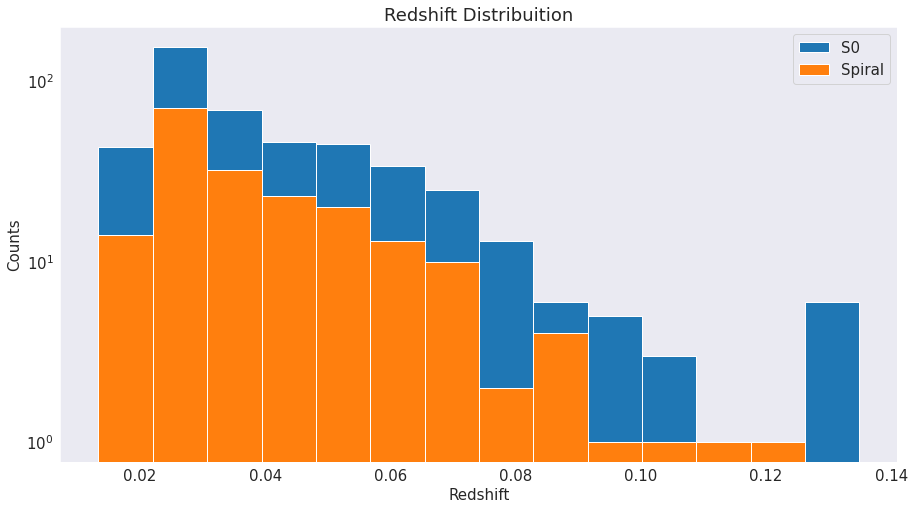

In [75]:
plt.figure(figsize=(15,8))

data = df_SB.z
min  = data.min()
max  = data.max()
bins = np.linspace(min,max,15)

plt.hist(data,bins)

data = df_SB0.z
min  = df_SB.z.min()
max  = df_SB.z.max()
bins = np.linspace(min,max,15)
plt.hist(data,bins)

plt.legend(['S0','Spiral'])
plt.xlabel('Redshift')
plt.ylabel('Counts')
plt.yscale('log')
plt.title('Redshift Distribuition')

In [84]:
np.unique(df_SB0['WHAN_Class'] )

array(['LSN', 'PSF', 'QB', 'QBSFB', 'SFB', 'SFBQB'], dtype=object)

In [85]:
df_SB0_sf = df_SB0[ (df_SB0['WHAN_Class'] == 'PSF') | (df_SB0['WHAN_Class'] == 'SFB') | (df_SB0['WHAN_Class'] == 'QBSFB') ]

In [89]:
df_SB0_sf

,plateifu,mangaid_x,objra_x,objdec_x,T,type,TType-cat,VI_morph,WHAN_Class,mangaid_y,objra_y,objdec_y,z,nsa_z,nsa_sersic_mass,nsa_sersic_ba,nsa_sersic_phi
17,8083-3702,1-38173,49.973226,0.391442,-0.584000,S0,Huertas,S0,PSF,1-38173,49.973226,0.391442,0.023844,0.023844,2.329210e+09,0.626054,50.08580
24,8138-6102,1-339061,117.144342,44.688285,-1.765000,S0,Huertas,S0,QBSFB,1-339061,117.144342,44.688285,0.020354,0.020354,1.396010e+10,0.464708,150.55000
40,8309-6101,1-576467,210.190320,51.728684,-0.788719,S0,SDSS-DeepLearning,S0,SFB,1-576467,210.190318,51.728684,0.069673,0.069673,5.248720e+10,0.580494,64.89850
49,8331-6104,1-250969,206.296274,42.319513,1.847000,Sab,Huertas,S0,QBSFB,1-250969,206.296274,42.319513,0.028281,0.028281,7.456170e+09,0.498883,54.76780
52,8335-6101,1-251788,215.229241,40.121027,-3.342000,EII,Huertas,S0,PSF,1-251788,215.229241,40.121027,0.017542,0.017542,9.201510e+09,0.800217,21.59410
71,8484-3702,1-94027,247.730865,45.880049,2.325000,Sab,Huertas,S0,QBSFB,1-94027,247.730865,45.880049,0.032686,0.032686,2.318260e+10,0.311126,4.55273
72,8486-6102,1-134020,238.046894,48.043916,3.107000,Sab,Huertas,S0,PSF,1-134020,238.046894,48.043916,0.019327,0.019327,2.080950e+09,0.379217,156.12100
74,8551-9102,1-247882,235.669362,45.432086,3.456000,Sab,Huertas,S0,PSF,1-247882,235.669362,45.432086,0.037614,0.037614,2.353330e+09,0.486889,88.14520
75,8553-12705,1-90901,235.463882,55.467854,2.020000,Sab,Huertas,S0,SFB,1-90901,235.463882,55.467854,0.048214,0.048214,5.822690e+09,0.370296,69.95750
85,8600-1901,1-633729,242.585225,43.009643,-0.646000,S0,Huertas,S0,PSF,1-633729,242.585225,43.009643,0.025213,0.025213,4.347810e+09,0.606152,130.51100


In [ ]:
with open('data/kurk_manga_bar_s0.ascii',mode='r') as f:
  lines = f.readlines()
  f.close()

dat = []
for line in lines[1:]:
  dat.append([float(item) if i not in [0,1,2] else item for i,item in enumerate(line.split())])

df = pd.DataFrame(dat, columns = lines[0].split()[1:])

## **Saving to Google Drive**

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


Choose a location in your drive

In [ ]:
cd '/content/gdrive/MyDrive/Star forming Bars in S0 Galaxies/SF Bar BPT/'

/content/gdrive/MyDrive/Star forming Bars in S0 Galaxies/SF Bar BPT


# **2D Decomposition**

In [ ]:
for plateifu in ['8133-3701'] : 
    
    maps = Maps(plateifu=plateifu)
    mangaid=maps.mangaid
    # Set the size of image cutout 
    scale = maps.wcs.to_header()['PC2_2']*3600
    size = 2*maps.wcs.to_header()['CRPIX1']*scale
    # Get SDSS Image
    optical = maps.getImage()
    optical.get_new_cutout(size,size,scale=size/512)
    out = df[df.plateifu==plateifu]

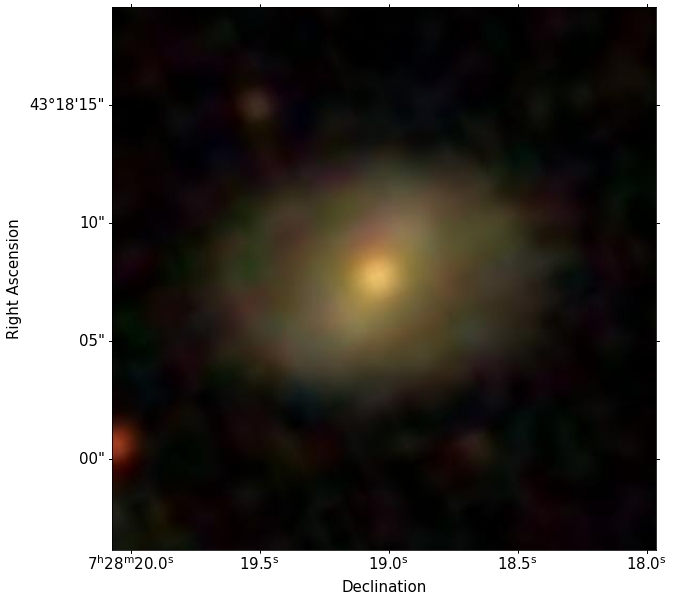

In [ ]:
optical.plot(with_axes=True)

In [ ]:
out

,SDSS_dr8objid,plateifu,mangaid,logMass,Bar/Ti,B/Ti,u-r-disc,u-r-bar,u-r-bulge,g-i-disc,g-i-bar,g-i-bulge,n-disc,re-disc,ba-disc,n-bar,re-bar,ba-bar,n-bulge,re-bulge,ba-bulge
45,1237663917335183755,8133-3701,1-377686,10.25,0.21,0.11,1.95,2.43,3.13,0.9,1.06,1.76,1.0,9.49,0.72,0.44,5.91,0.36,0.3,0.95,0.83


In [ ]:
filter_r = np.rot90(np.array(optical.data)[:,:,0].T )
ell      = iso.Ellipse(filter_r)
isolist  = ell.fit_image()
model    = iso.build_ellipse_model(filter_r.shape,isolist) 

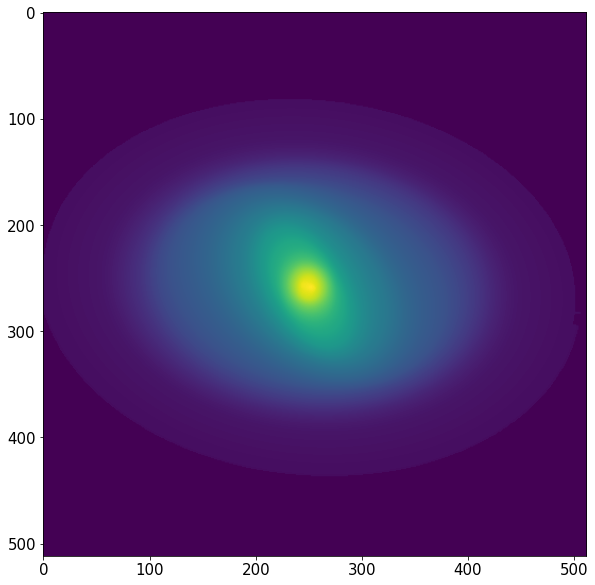

In [ ]:
plt.imshow(model)

In [ ]:
for i, row in isolist.to_table().to_pandas().sort_values('pa').iterrows():

  fig = plt.figure(figsize=(20,8), constrained_layout=True)

  ax1  = fig.add_subplot(121,projection=optical.wcs)
  ax1.imshow(filter_r, cmap = 'jet')

  ax2  = fig.add_subplot(122,projection=optical.wcs)
  ax2.imshow(model, cmap = 'jet')

  position =[row.x0,row.y0]

  # Disk
  a = out['re-disc'].values[0]*256/size
  b = out['ba-disc'].values[0]*a

  aperture = phot.aperture.EllipticalAperture(position, a=a,b=b,theta=row.pa*(np.pi/180))
  aperture.plot(axes=ax1, color='red', lw=1.5)
  aperture.plot(axes=ax2, color='red', lw=1.5)

  # Bulge

  a = out['re-bulge'].values[0]*256/size
  b = out['ba-bulge'].values[0]*a

  aperture = phot.aperture.EllipticalAperture(position, a=a,b=b,theta=row.pa*(np.pi/180))
  aperture.plot(axes=ax1, color='blue', lw=1.5)
  aperture.plot(axes=ax2, color='blue', lw=1.5)

  # Bar

  a = out['re-bar'].values[0]*256/size
  b = out['ba-bar'].values[0]*a

  aperture = phot.aperture.EllipticalAperture(position, a=a,b=b,theta=row.pa*(np.pi/180))
  aperture.plot(axes=ax1, color='black', lw=1.5)
  aperture.plot(axes=ax2, color='black', lw=1.5)

  fig.suptitle(f'Index = {i} | PA = {row.pa}')
  fig.legend(['Disk','Bulge','Bar'])
  plt.show()

In [ ]:
for i, row in isolist.to_table().to_pandas().iterrows():

  fig = plt.figure(figsize=(20,8), constrained_layout=True)

  ax1  = fig.add_subplot(121,projection=optical.wcs)
  ax1.imshow(filter_r, cmap = 'jet')

  ax2  = fig.add_subplot(122,projection=optical.wcs)
  ax2.imshow(model, cmap = 'jet')

  position =[row.x0,row.y0]

  a = row.sma
  if a==0:
    a=0.00001
  b = (1-row.ellipticity)*a

  aperture = phot.aperture.EllipticalAperture(position, a=a,b=b,theta=row.pa*(np.pi/180))
  aperture.plot(axes=ax1, color='purple', lw=1.5)
  aperture.plot(axes=ax2, color='purple', lw=1.5)

  # Disk
  a = out['re-disc'].values[0]*256/size
  b = out['ba-disc'].values[0]*a

  aperture = phot.aperture.EllipticalAperture(position, a=a,b=b,theta=row.pa*(np.pi/180))
  aperture.plot(axes=ax1, color='red', lw=1.5)
  aperture.plot(axes=ax2, color='red', lw=1.5)

  # Bulge

  a = out['re-bulge'].values[0]*256/size
  b = out['ba-bulge'].values[0]*a

  aperture = phot.aperture.EllipticalAperture(position, a=a,b=b,theta=row.pa*(np.pi/180))
  aperture.plot(axes=ax1, color='blue', lw=1.5)
  aperture.plot(axes=ax2, color='blue', lw=1.5)

  # Bar

  a = out['re-bar'].values[0]*256/size
  b = out['ba-bar'].values[0]*a

  aperture = phot.aperture.EllipticalAperture(position, a=a,b=b,theta=row.pa*(np.pi/180))
  aperture.plot(axes=ax1, color='black', lw=1.5)
  aperture.plot(axes=ax2, color='black', lw=1.5)

  fig.suptitle(f'Index = {i} | PA = {row.pa} | semi major axis = {row.sma}')
  fig.legend(['Disk','Bulge','Bar'])
  plt.show()

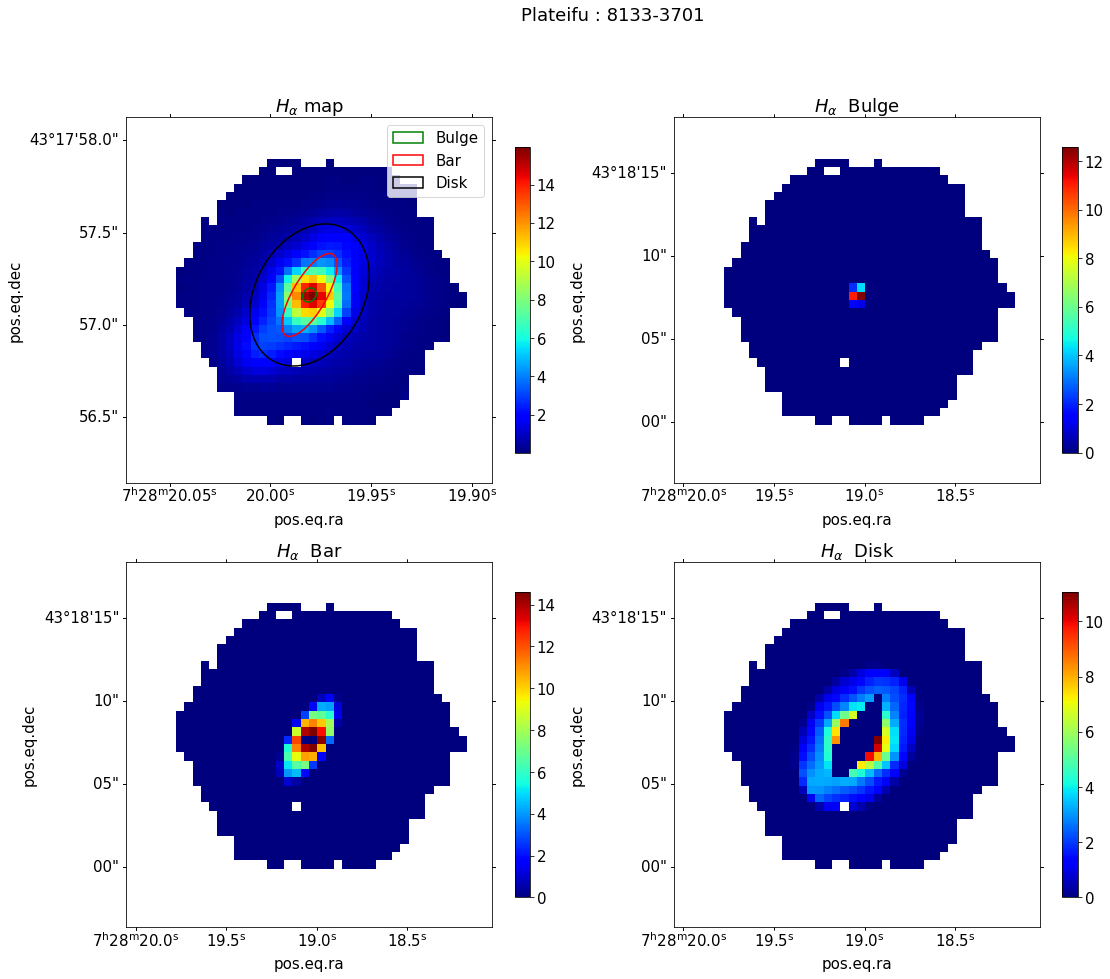

In [ ]:
fig = plt.figure( figsize = (18,15))

ha = maps.emline_gflux_ha_6564

ha_img = goodspax(ha)

arr_size = ha.shape[0]//2

ax1 = fig.add_subplot(221,projection=optical.wcs)
ax2 = fig.add_subplot(222,projection=maps.wcs,slices = ['x','y',0])
ax3 = fig.add_subplot(223,projection=maps.wcs,slices = ['x','y',0])
ax4 = fig.add_subplot(224,projection=maps.wcs,slices = ['x','y',0])

img = ax1.imshow(ha_img, cmap = 'jet')
plt.colorbar(img,ax = ax1,anchor=(0,5),shrink=0.824)
ax1.set_title(r'$H_{\alpha}$ map')

row = [row for i,row in isolist.to_table().to_pandas().iterrows() if i==54][0]
position =[row.x0*22/256,row.y0*22/256]

# Bulge

a = out['re-bulge'].values[0]*arr_size /size
b = out['ba-bulge'].values[0]*a

aperture = phot.aperture.EllipticalAperture(position, a=a,b=b,theta=row.pa*(np.pi/180))
aperture.plot(axes=ax1, color='green', lw=1.5)

mask_bulge = aperture.to_mask().to_image((arr_size*2, arr_size*2))

img = ax2.imshow(ha_img*mask_bulge,cmap = 'jet')
plt.colorbar(img,ax = ax2,anchor=(0,5),shrink=0.824)
ax2.set_title(r'$H_{\alpha}$  Bulge')

# Bar

a = out['re-bar'].values[0]*arr_size/size
b = out['ba-bar'].values[0]*a

aperture = phot.aperture.EllipticalAperture(position, a=a,b=b,theta=60*(np.pi/180))
aperture.plot(axes=ax1, color='red', lw=1.5)

mask_bar =   aperture.to_mask().to_image((arr_size*2, arr_size*2))

bar_annulus = np.where(mask_bulge + mask_bar>1.5,0,mask_bar)

img = ax3.imshow(ha_img*bar_annulus, cmap = 'jet')
plt.colorbar(img,ax = ax3,anchor=(0,5),shrink=0.824)
ax3.set_title(r'$H_{\alpha}$  Bar')

# Disk

a = out['re-disc'].values[0]*arr_size/size
b = out['ba-disc'].values[0]*a

aperture = phot.aperture.EllipticalAperture(position, a=a,b=b,theta=row.pa**(np.pi/180))
aperture.plot(axes=ax1, color='black', lw=1.5)

mask_disk = aperture.to_mask().to_image((arr_size*2, arr_size*2))

disk_annulus = np.where(mask_disk + mask_bar >1.5,0,mask_disk)

img = ax4.imshow(ha_img*disk_annulus, cmap = 'jet')

plt.colorbar(img,ax = ax4,anchor=(0,5),shrink=0.824)

ax4.set_title(r'$H_{\alpha}$  Disk')
ax1.legend(['Bulge','Bar','Disk'])

fig.suptitle(f'Plateifu : 8133-3701')

plt.show()

# **Maps with Mapplot**

[WARNING]: drpall file not found. Downloading it. (MarvinUserWarning)
Progress: 100%|██████████| 1/1 [00:05<00:00,  5.01s/files, n_files=1, n_streams=1]


SDSS_ACCESS> Done!


[WARNING]: divide by zero encountered in log10 (RuntimeWarning)
[WARNING]: invalid value encountered in multiply (RuntimeWarning)
[WARNING]: divide by zero encountered in power (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)
[WARNING]: divide by zero encountered in log10 (RuntimeWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked ele

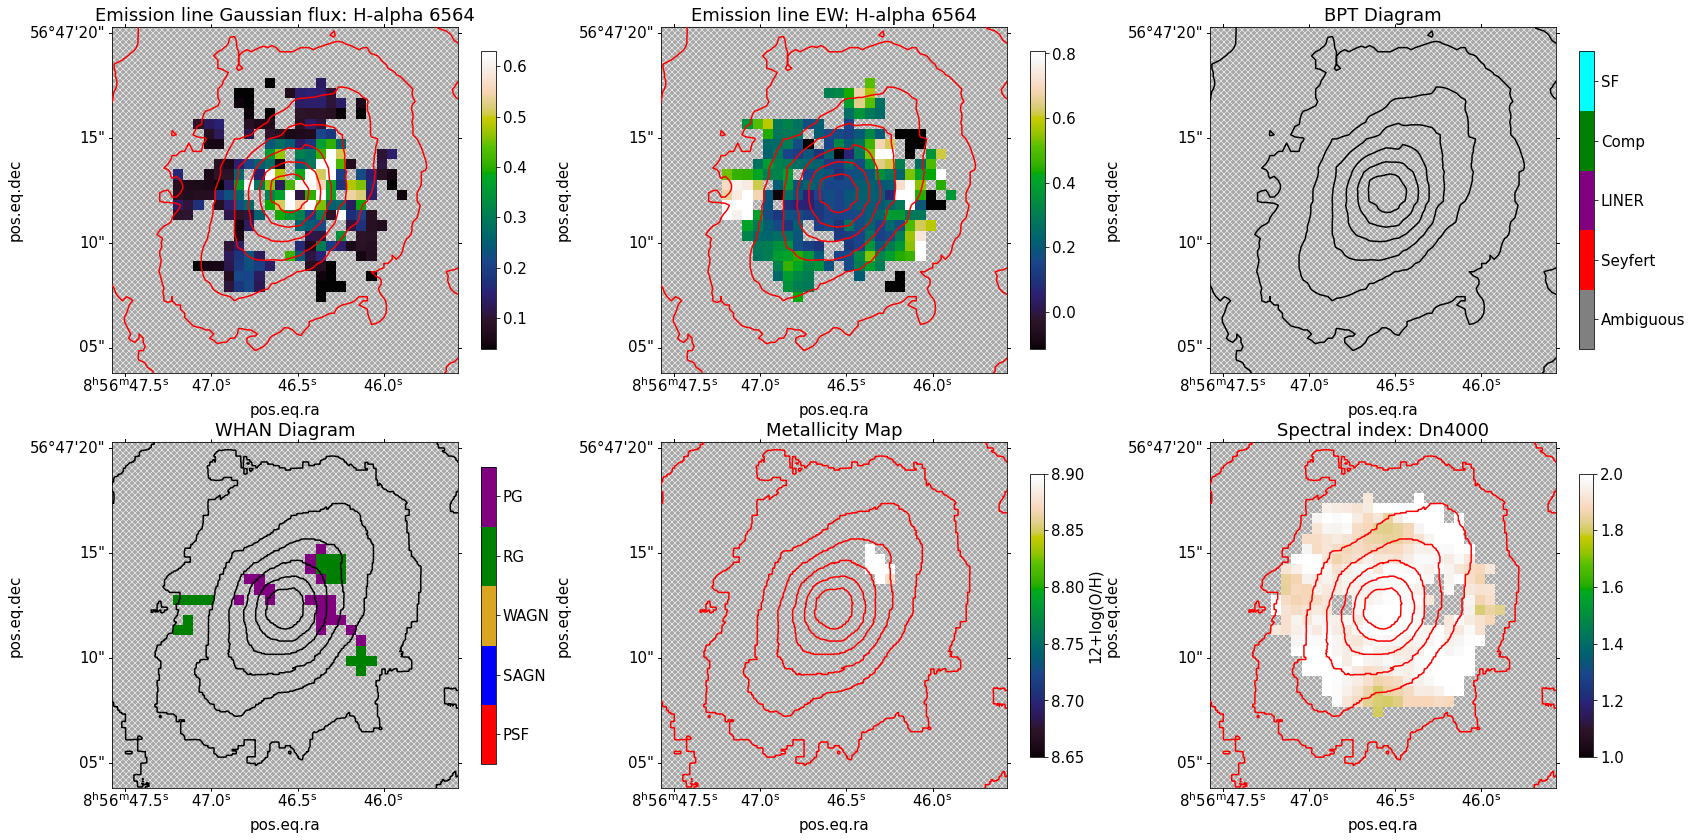

In [ ]:
download = 0
format = 'png'

for plateifu in df.plateifu : 
    
    maps = Maps(plateifu=plateifu)
    mangaid=maps.mangaid
    # Set the size of image cutout 
    scale = maps.wcs.to_header()['PC2_2']*3600
    size = 2*maps.wcs.to_header()['CRPIX1']*scale
    # Get SDSS Image
    optical = maps.getImage()

    # Crop Image to match IFU size
    optical.get_new_cutout(size,size)
    gs = gridspec.GridSpec(2,3) 

    fig=plt.figure(figsize=(27,14))

    filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
    levels=[60.,  90., 120., 150., 180., 210., 240.]


    # H-alpha with optical contours
    ax1 = fig.add_subplot(gs[0,0],projection=maps.wcs,slices=('x','y',0))
    ha = maps.emline_gflux_ha_6564

    ax1.grid(True,which='major')
    fig,ax1,cb=mapplot.plot(dapmap=ha,ax=ax1,fig=fig,return_cb=True)
    ax1.set_autoscale_on(False)
    ax1.contour(filter_r, transform=ax1.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
    cb.remove()
    cb=plt.colorbar(ax1.get_images()[1],ax=ax1,anchor=(0,5),shrink=0.86)
    ax1.set_xlabel('pos.eq.ra')
    ax1.set_ylabel('pos.eq.dec')
    
    # H alpha EW
    ewha = maps['emline_sew_ha_6564']
    
    ax2 = fig.add_subplot(gs[0,1],projection=maps.wcs,slices=('x','y',0))

    ax2.grid(True,which='major')
    fig,ax2,cb=mapplot.plot(dapmap=ewha,ax=ax2,fig=fig,return_cb=True)
    ax2.set_autoscale_on(False)
    ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
    cb.remove()
    cb=plt.colorbar(ax2.get_images()[1],ax=ax2,anchor=(0,5),shrink=0.86)
    ax2.set_xlabel('pos.eq.ra')
    ax2.set_ylabel('pos.eq.dec')

    #------------------------------------------------------------------------------------------
    
    mask, fig_bpt, ax_bpt = maps.get_bpt(show_plot=False)

    # Complete the missing lines

    SF = mask['sf']['global'].astype(np.float64)
    COMP = mask['comp']['global'].astype(np.float64)
    SEYF = mask['seyfert']['global'].astype(np.float64)
    LIN = mask['liner']['global'].astype(np.float64)
    AMB = mask['ambiguous']['global'].astype(np.float64)

    # Giving labels to each class

    SF   *= 5
    COMP *= 4
    SEYF *= 3
    LIN  *= 2
    AMB  *= 1

    # Sum the above masks
    bpt = SF + COMP + SEYF + LIN + AMB

    # Let's make a color map for BPT map

    cmap = colors.ListedColormap(['grey','red', 'purple', 'green', 'cyan'])

    # IFU nocov mask
    ha = maps.emline_gew_ha_6564 # For getting pixmask

    nocov = ha.pixmask.get_mask('NOCOV')

    # Plot

    ax3 = fig.add_subplot(gs[0,2],projection=maps.wcs,slices=('x','y',0))
    # Mapplot plot

    fig, ax3, cb = mapplot.plot(value=bpt, ivar = bpt, mask=nocov, cmap=cmap,fig=fig,ax=ax3, use_masks='NOCOV', return_cb=True, cbrange=(0.5, 5.5), title='BPT Diagram')

    ax3.set_autoscale_on(False)

    # Over plot optical contours with black color and given levels

    levels = [60., 90., 120., 150., 180., 210., 240.]

    # Get SDSS image 

    optical = maps.getImage()

    # Prepare for plotting contours

    # Set the size of image cutout

    scale = maps.wcs.to_header()['PC2_2']*3600  # Gives arcsec/ pixel

    size = 2*maps.wcs.to_header()['CRPIX1']*scale # Give angular size in arcseconds

    # Getting new cutout

    optical.get_new_cutout(width = size, height = size)

    filter_r = np.rot90(np.array(optical.data)[:,:,0].T )

    # Remove grid
    ax3.grid(False)

    # Plot contours and transform it with optical.wcs and assign the contours black color with levels = levels and zorder =11
    ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)

    # Remove default colorbar
    cb.remove()
    # Generate new color bar
    cb = plt.colorbar(ax3.get_images()[1],ax=ax3,anchor=(0,5),shrink=0.86)
    cb.set_ticks([1, 2, 3, 4, 5])
    cb.set_ticklabels(['Ambiguous','Seyfert','LINER','Comp', 'SF'])
    # Set x and y label
    ax3.set_xlabel('pos.eq.ra')
    ax3.set_ylabel('pos.eq.dec')


    # WHAN
    nii = maps.emline_gflux_nii_6585  # Get emline gaussian flux of nii with wavelength 6585
    ha = maps.emline_gflux_ha_6564    # Get emline gaussian flux of H alpha  with wavelength 6564
    niiha = nii/ha

    ewha = maps['emline_sew_ha_6564']  # Get emline_sew of H alpha  with wavelength 6564
    ewnii = maps['emline_sew_nii_6585'] # Get emline_sew of nii with wavelength 6585

    # Take the log of the NII/Ha ratio
    logniiha = np.log10(niiha.value)

    # Create the WHAN categories. Hint : Use ewha.value, ewnii.value, and logniiha

    psf = (logniiha < -0.4) & (ewha.value > 3)                        # Pure Star Forming
    sagn = (logniiha > -0.4) & (ewha.value > 6)                       # Strong AGN
    wagn = (logniiha > -0.4) & ((ewha.value > 3) & (ewha.value < 6))  # Weak AGN
    rg = ewha.value < 3                                               # Retired Galaxy  
    pg = (ewha.value < 0.5) & (ewnii.value < 0.5)                     # Passive Galaxy

    # Create a custom array for a WHAN categories (we copy the EW Ha array just to get a 2d-array of the original size)

    value = ewha.value.copy()
    value[psf]  = 1     # pure star-forming 
    value[sagn] = 2     # strong agn
    value[wagn] = 3     # weak agn
    value[rg]   = 4     # retired galaxies
    value[pg]   = 5     # passive galaxies

    # Set ivar to 0 where the SNR < 1
    niiha_low_snr = mapplot.mask_low_snr(niiha.value, niiha.ivar, snr_min=1)
    ewha_low_snr  = mapplot.mask_low_snr(ewha.value, ewha.ivar, snr_min=1)
    ewnii_low_snr = mapplot.mask_low_snr(ewnii.value, ewnii.ivar, snr_min=1)
    low_snr       = np.logical_or(niiha_low_snr, ewha_low_snr, ewnii_low_snr)

    ivar = ewha.value.copy()
    ivar[low_snr] = 0
    value[low_snr] = 6

    #------------------------------------------------------------------------------------------

    # WHAN IFU

    ax4 = fig.add_subplot(gs[1,0],projection=maps.wcs,slices=('x','y',0))
    #  Remove grid
    ax4.grid(False)

    # Create colomap with colors 'red', 'blue', 'goldenrod', 'green', 'purple'
    cmap = colors.ListedColormap(['red', 'blue', 'goldenrod', 'green', 'purple'])

    # Get nocov mask from ewha map

    nocov = ewha.pixmask.get_mask('NOCOV')

    # Complete the mapplot.plot  function call
    fig, ax4, cb = mapplot.plot(value=value, ivar=ivar, mask=nocov, cmap=cmap,fig=fig,ax=ax4, use_masks='NOCOV', return_cb=True, cbrange=(0.5, 5.5), title='WHAN Diagram')

    # Set autoscale to False
    ax4.set_autoscale_on(False)

    # Get SDSS optical image
    optical = maps.getImage()

    # Set the size of image cutout 
    scale = maps.wcs.to_header()['PC2_2']*3600
    size = 2*maps.wcs.to_header()['CRPIX1']*scale

    # Get new cutout with new size
    optical.get_new_cutout(size,size,size/512)

    # Slice the optical image and get r band data
    filter_r=np.rot90(np.array(optical.data)[:,:,0].T )

    # Assign levels [60.,  90., 120., 150., 180., 210., 240.]
    levels = [60.,  90., 120., 150., 180., 210., 240.]

    # Create contour of filter_r and transform it using optical.wcs. Give color = 'black' and zorder=11
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)

    # Remove default colorbar
    cb.remove()

    # Create new color bar
    cb=plt.colorbar(ax4.get_images()[1],ax=ax4,anchor=(0,5),shrink=0.86)

    # Set ticks [1, 2, 3, 4, 5]
    cb.set_ticks([1, 2, 3, 4, 5])

    # Set ticklabels ['PSF', 'SAGN', 'WAGN', 'RG', 'PG']
    cb.set_ticklabels(['PSF', 'SAGN', 'WAGN', 'RG', 'PG'])

    # Set axes labels
    ax4.set_xlabel('pos.eq.ra')
    ax4.set_ylabel('pos.eq.dec')
    
    #------------------------------------------------------------------------------------------

    # Metallicity Map
    ax5 = fig.add_subplot(gs[1,1],projection=maps.wcs,slices=('x','y',0))
    nii = maps.emline_gflux_nii_6585
    n2 = nii/ ha
    logn2 = np.log10(n2)
    oh = 8.90 + 0.57 * logn2

    mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
    min_snr = 3.
    mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
    mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)

    mask =  mask_bad_data | mask_nii_low_snr | mask_ha_low_snr
    ax5.grid(True,which='major')
    fig,ax5,cb=mapplot.plot(dapmap=oh,mask=mask,ax=ax5,fig=fig,return_cb=True,cbrange=[8.65,8.9],title='Metallicity Map')
    ax5.set_autoscale_on(False)
    ax5.contour(filter_r, transform=ax5.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
    cb.remove()
    cb=plt.colorbar(ax5.get_images()[1],ax=ax5,anchor=(0,5),shrink=0.82,label= '12+log(O/H)')
    ax5.set_xlabel('pos.eq.ra')
    ax5.set_ylabel('pos.eq.dec')

     #------------------------------------------------------------------------------------------

    # DN 4000 with optical contours    
    ax6 = fig.add_subplot(gs[1,2],projection=maps.wcs,slices=('x','y',0))

    dn = maps.specindex_dn4000
    ax6.grid(True,which='major')
    fig,ax6,cb=mapplot.plot(dapmap=dn,ax=ax6,fig=fig,return_cb=True,cbrange=[1,2])
    ax6.set_autoscale_on(False)
    ax6.contour(filter_r, transform=ax6.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
    cb.remove()
    cb=plt.colorbar(ax6.get_images()[1],ax=ax6,anchor=(0,5),shrink=0.82)
    ax6.set_xlabel('pos.eq.ra')
    ax6.set_ylabel('pos.eq.dec')

    fig.suptitle(" ",size=20,va='top',y=0.9)
    plt.subplots_adjust(left=0.1)
    if download:
      fig.savefig(f'{plateifu}maps',bbox_inches = 'tight',format = format)
  
    #------------------------------------------------------------------------------------------
    plt.pause(0.5)
    break

# **Maps with Matplotlib**

In [ ]:
use_masks = ['NOCOV','LOWCOV','DEADFIBER','FORESTAR','NOVALUE','UNRELIABLE','MATHERROR','FITFAILED','NOCORRECTION','MULTICOMP','NEARBOUND','DONOTUSE']
def goodspax(dapmap,type=None):
  if type==None:
    bad_data = dapmap.pixmask.get_mask(use_masks,dtype = np.bool)
    low_snr = abs(dapmap.value*np.sqrt(dapmap.ivar))<1.0
    mask = np.logical_or.reduce((bad_data, low_snr))
    mask = np.where(mask==True,np.nan,1)

  elif type=='vel':

    bad_data = dapmap.pixmask.get_mask(use_masks,dtype = np.bool)
    low_snr = abs(dapmap.value*np.sqrt(dapmap.ivar))<0.0
    mask = np.logical_or.reduce((bad_data, low_snr))
    mask = np.where(mask==True,1e-11,1)

  return dapmap.value*mask

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc68da1a110>)

[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)


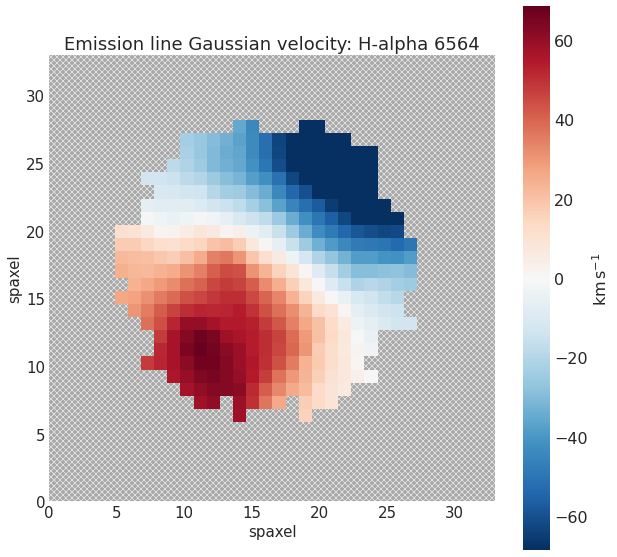

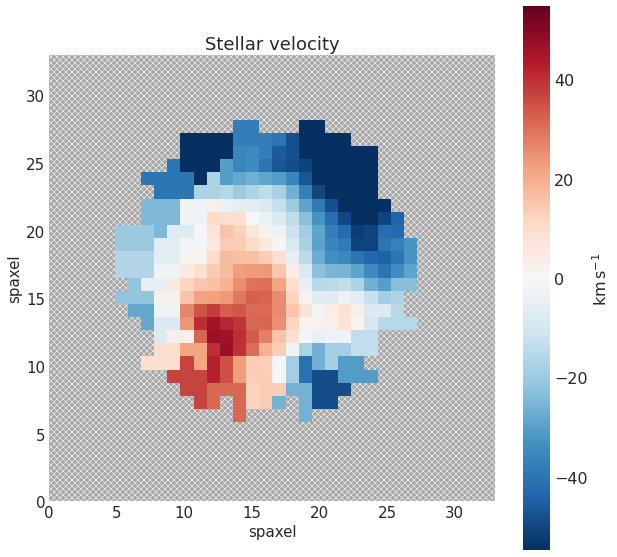

In [ ]:
maps = Maps(plateifu='8600-1901',mode='remote')
havel = maps.emline_gvel_ha_6564
stvel = maps.stellar_vel
havel.plot()
stvel.plot()

  Kin PA: 147.0  +/-   6.2  (3*sigma error)
Velocity Offset: 0.00


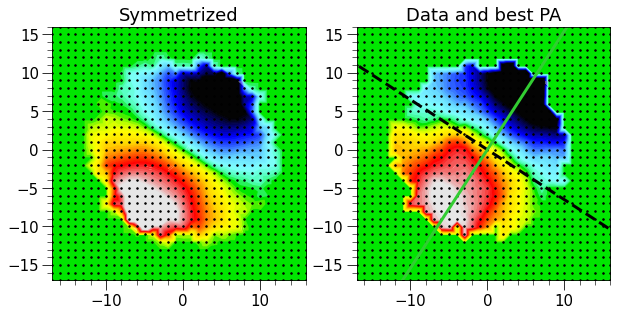

  Kin PA: 142.5  +/-   9.2  (3*sigma error)
Velocity Offset: 0.00


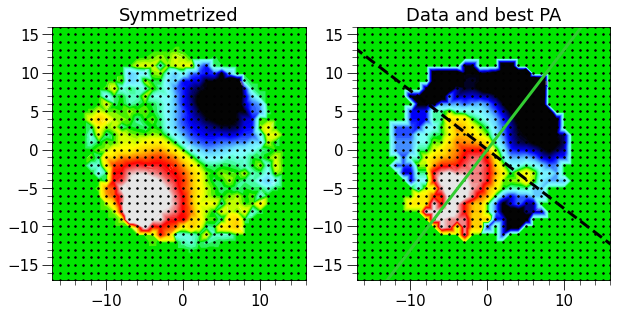

In [ ]:
data = goodspax(havel,'vel')
l = data.shape[0]//2
y,x = np.mgrid[-l:l,-l:l]

pa_ha, pa_err, offset = paf.fit_kinematic_pa(x,y,data)
plt.show()

data = goodspax(stvel,'vel')
l = data.shape[0]//2
y,x = np.mgrid[-l:l,-l:l]

pa_st, pa_err, offset = paf.fit_kinematic_pa(x,y,data)

  Kin PA: 142.5  +/-   9.2  (3*sigma error)
Velocity Offset: 0.00


Text(0.5, 1.0, 'H alpha vel')

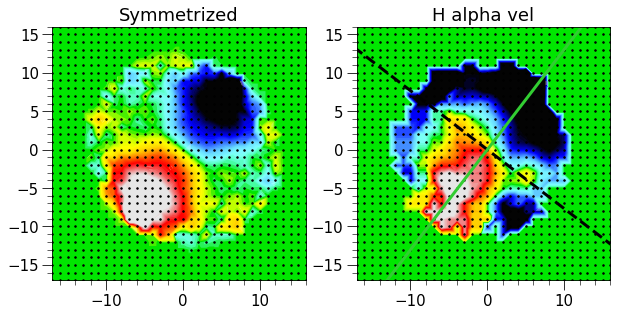

In [ ]:
pa, pa_err, offset = paf.fit_kinematic_pa(x,y,data)
plt.title('H alpha vel')

Text(0.5, 1.0, 'Blah')

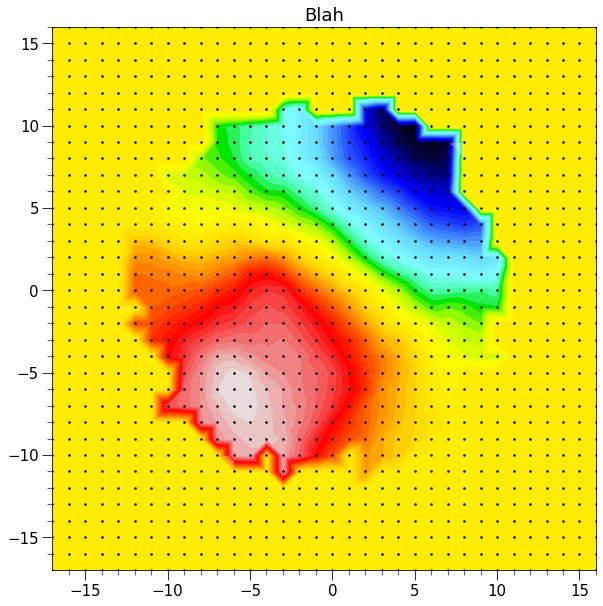

In [ ]:
fig = paf.plot_velfield(x,y,data)
plt.title("Blah")

AttributeError: ignored

[WARNING]: divide by zero encountered in log10 (RuntimeWarning)
[WARNING]: invalid value encountered in multiply (RuntimeWarning)
[WARNING]: divide by zero encountered in power (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)
[WARNING]: divide by zero encountered in log10 (RuntimeWarning)
[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: divide by zero encountered in log10 (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)
[WARNING]: invalid value encountered in multiply (RuntimeWarning)
[WARNING]: invalid value encountered in multiply (RuntimeWarning)


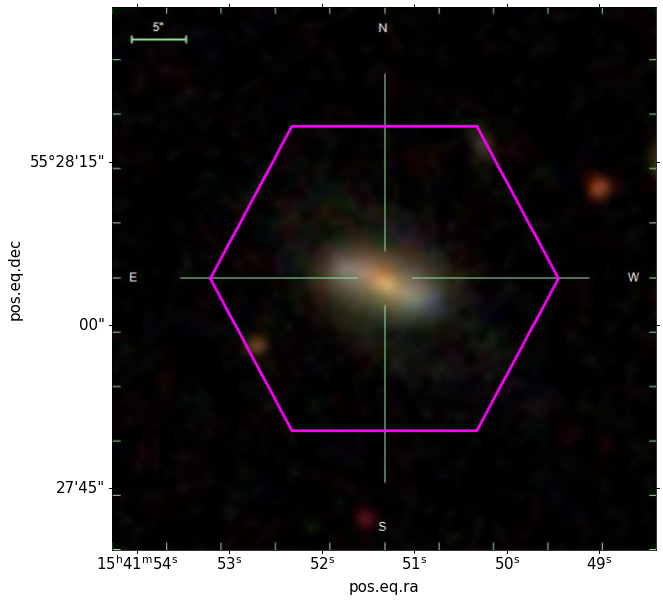

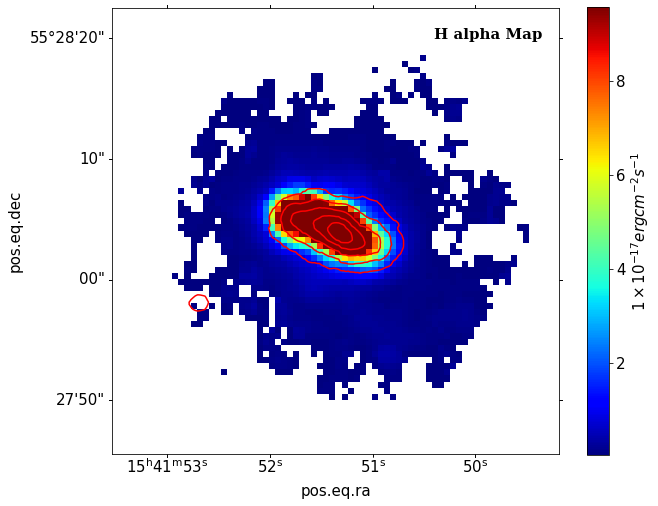

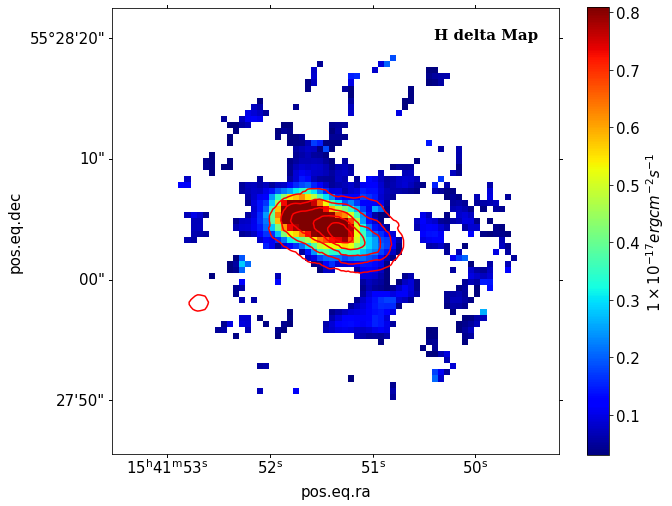

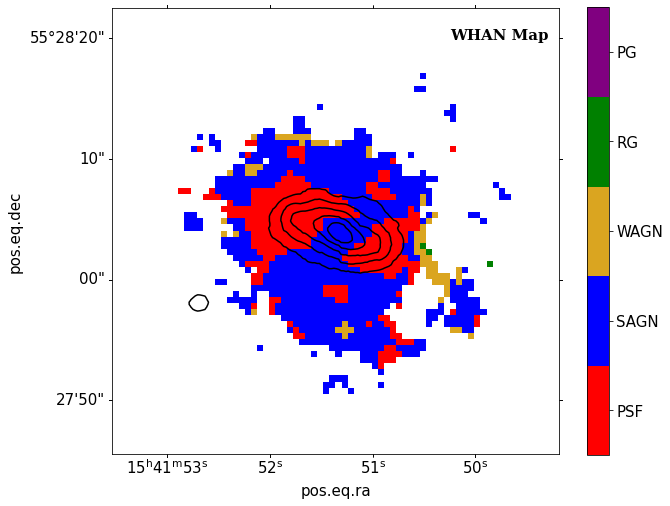

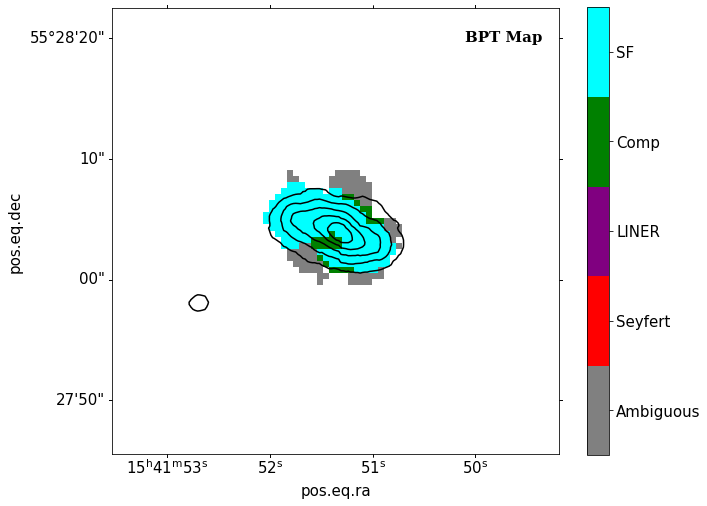

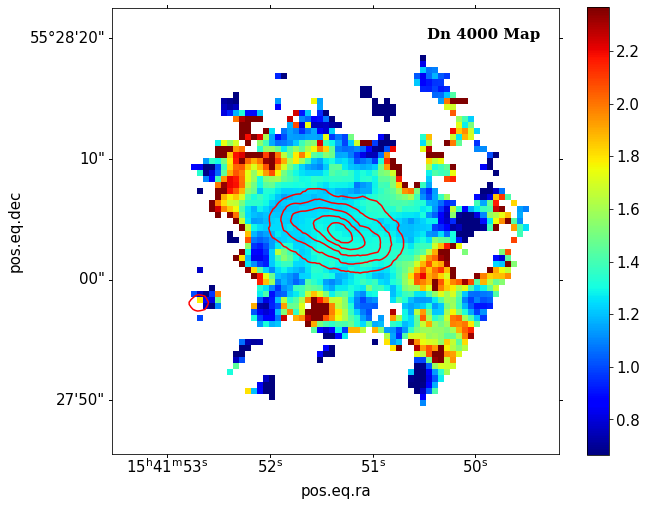

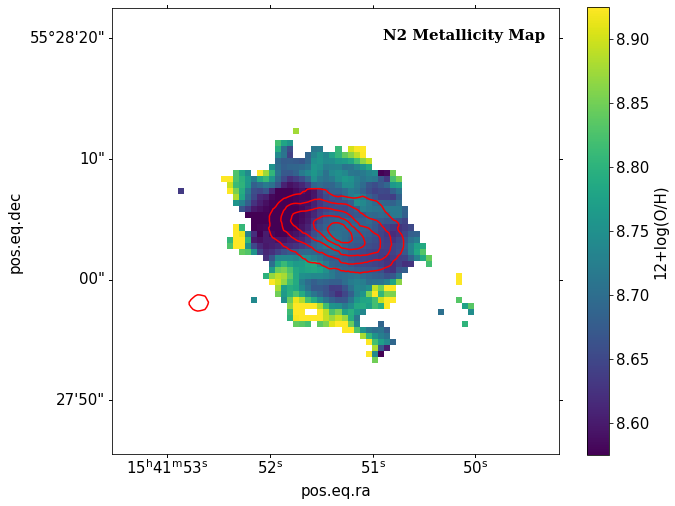

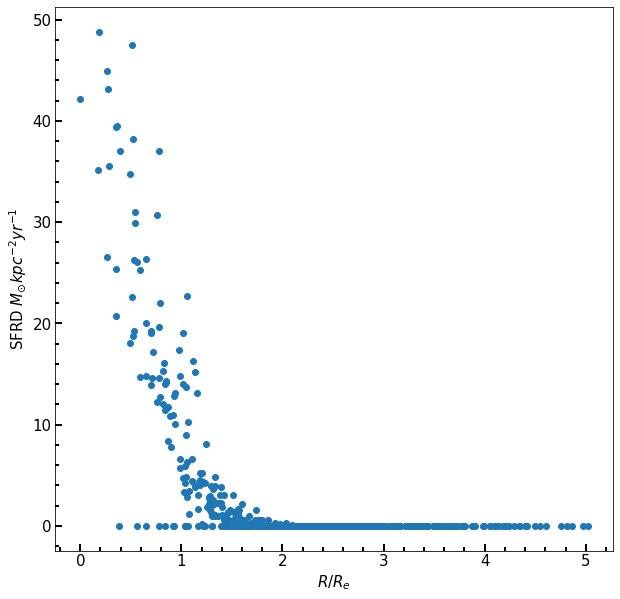

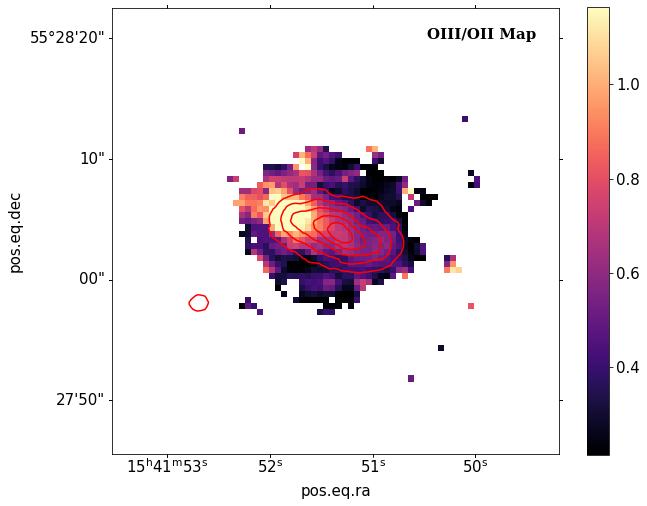

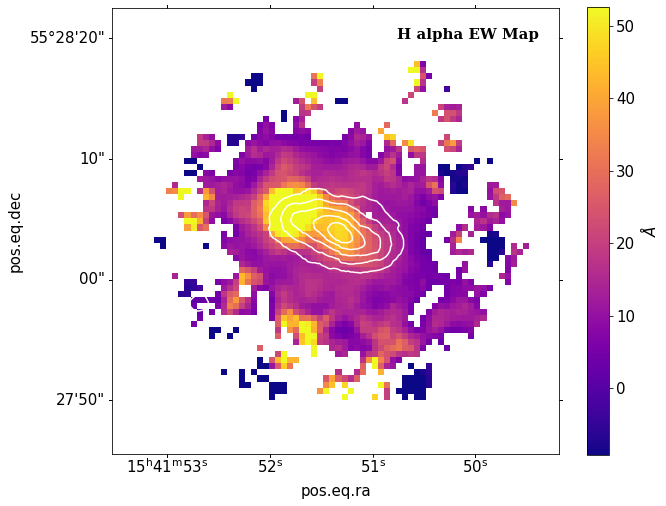

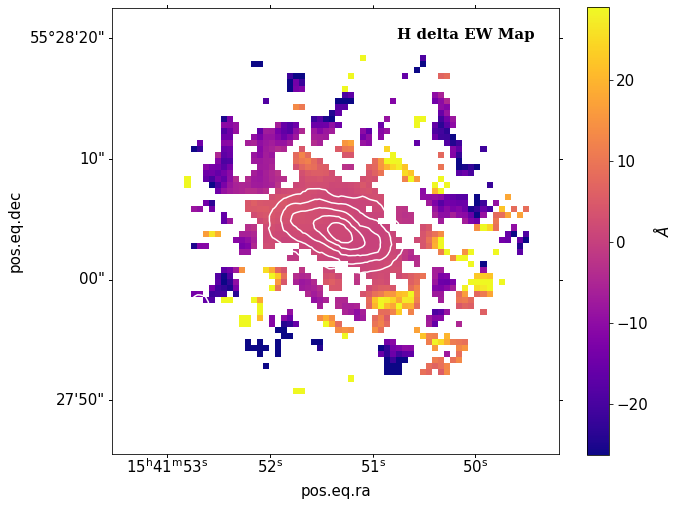

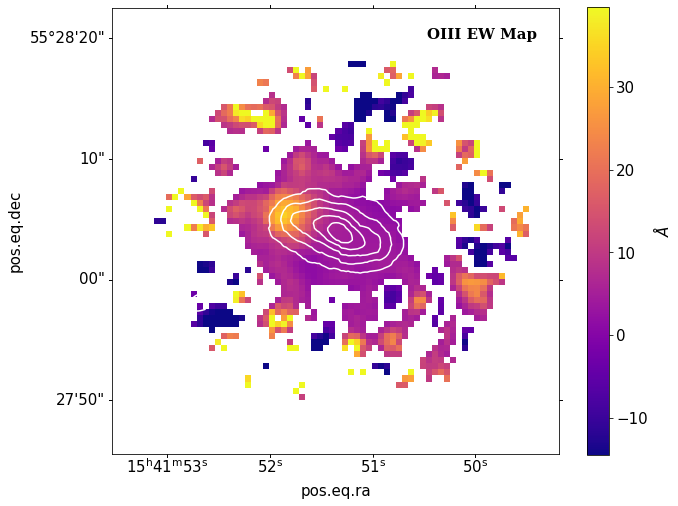

In [ ]:
download = 0
format = 'png'
for plateifu in [ '8553-12705','9181-9101', '8083-3702', '8600-1901', '8551-9102', '8946-6102', '8335-6101', '9049-3704']:

    if not os.path.exists(f'{plateifu}'):
        os.mkdir(f'{plateifu}')
  
    maps = Maps(plateifu=plateifu,mode='remote')
    mangaid = maps.mangaid

    # Set the size of image cutout 
    scale = maps.wcs.to_header()['PC2_2']*3600
    size = 2*maps.wcs.to_header()['CRPIX1']*scale

    # Get SDSS Image
    optical=maps.getImage()

    # Optical Image
    fig = plt.figure(figsize = (10,10))
    ax1 = fig.add_subplot(projection=optical.wcs)
    ax1.grid(False)
    ax1.imshow(optical.data)
    ax1.grid(False)
    if download:
        fig.savefig(f'{plateifu}/SDSS_cutout',bbox_inches = 'tight',format=format)
    
    #------------------------------------------------------------------------------------------
    
    # Crop Image to match IFU size

    optical.get_new_cutout(size,size)
    filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
    levels=[60.,  90., 120., 150., 180., 210., 240.]
    
  # H-alpha with optical contours

    fig = plt.figure(figsize = (10,10))
    ax3 = fig.add_subplot( projection=maps.wcs,slices=('x','y',0))
    ha = maps.emline_gflux_ha_6564

    ax3.grid(False)
    cbr = mapplot.plot(dapmap=ha,return_cbrange=True)
    img = ax3.imshow(goodspax(ha),vmin=cbr[0],vmax=cbr[1],cmap='jet')
    ax3.grid(False)
    ax3.set_autoscale_on(False)
    ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
    ax3.annotate(r'H alpha Map',(len(ha)-len(ha)/3.5,len(ha)-len(ha)/13),weight='bold',family='serif')
    cb=plt.colorbar(img,ax=ax3,anchor=(0,5),shrink=0.824)
    cb.set_label(r'$1\times10^{-17}ergcm^{-2}s^{-1}$')
    ax3.set_xlabel('pos.eq.ra')
    ax3.set_ylabel('pos.eq.dec')

    if download:
        fig.savefig(f'{plateifu}/H_alpha',bbox_inches = 'tight',format = format)
    #------------------------------------------------------------------------------------------

    # H-delta with optical contours

    fig = plt.figure(figsize = (10,10))
    ax3 = fig.add_subplot( projection=maps.wcs,slices=('x','y',0))
    ha = maps.emline_gflux_hdel_4102

    ax3.grid(False)
    cbr = mapplot.plot(dapmap=ha,return_cbrange=True)
    img = ax3.imshow(goodspax(ha),vmin=cbr[0],vmax=cbr[1],cmap='jet')
    ax3.grid(False)
    ax3.set_autoscale_on(False)
    ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
    ax3.annotate(r'H delta Map',(len(ha)-len(ha)/3.5,len(ha)-len(ha)/13),weight='bold',family='serif')
    cb=plt.colorbar(img,ax=ax3,anchor=(0,5),shrink=0.824)
    cb.set_label(r'$1\times10^{-17}ergcm^{-2}s^{-1}$')
    ax3.set_xlabel('pos.eq.ra')
    ax3.set_ylabel('pos.eq.dec')

    if download:
        fig.savefig(f'{plateifu}/H_delta',bbox_inches = 'tight',format = format)
    #------------------------------------------------------------------------------------------

    # WHAN Map

    # grab the NII/Ha flux ratio, Ha and NII equivalent width arrays
    nii=maps.emli40ne_gflux_nii_6585
    ha=maps.emline_gflux_ha_6564
    niiha = nii/ha
    ewha = maps['emline_sew_ha_6564']
    ewnii = maps['emline_sew_nii_6585']
    # take the log of the NII/Ha ratio
    logniiha = np.log10(niiha.value)

    # create the WHAN categories
    psf = (logniiha < -0.4) & (ewha.value > 3)
    sagn = (logniiha > -0.4) & (ewha.value > 6)
    wagn = (logniiha > -0.4) & ((ewha.value > 3) & (ewha.value < 6))
    rg = ewha.value < 3
    pg = (ewha.value < 0.5) & (ewnii.value < 0.5) 

    # create a custom array for a WHAN categories (we copy the EW Ha array just to get a 2d-array of the original size)
    value = ewha.value.copy()
    value[psf]  = 1     # pure star-forming 
    value[sagn] = 2     # strong agn
    value[wagn] = 3     # weak agn
    value[rg]   = 4     # retired galaxies
    value[pg]   = 5     # passive galaxies

    # Set ivar to 0 where the SNR < 1
    niiha_low_snr = mapplot.mask_low_snr(niiha.value, niiha.ivar, snr_min=1)
    ewha_low_snr = mapplot.mask_low_snr(ewha.value, ewha.ivar, snr_min=1)
    ewnii_low_snr = mapplot.mask_low_snr(ewnii.value, ewnii.ivar, snr_min=1)
    low_snr = np.logical_or(niiha_low_snr, ewha_low_snr, ewnii_low_snr)

    ivar = ewha.value.copy()
    ivar[low_snr] = 0
    value[low_snr] = np.nan

    # Set the size of image cutout 
    scale = maps.wcs.to_header()['PC2_2']*3600
    size = 2*maps.wcs.to_header()['CRPIX1']*scale

    # WHAN IFU
    fig = plt.figure(figsize = (10,10))
    ax2 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
    ax2.grid(False)
    cmap = colors.ListedColormap(['red', 'blue', 'goldenrod', 'green', 'purple'])
    nocov = ewha.pixmask.get_mask('NOCOV',dtype=np.bool)
    mask = np.where(nocov==True,np.nan,1)
    #fig, ax2, cb = mapplot.plot(value=value, ivar=ivar, mask=nocov, cmap=cmap,fig=fig,ax=ax2, use_masks='NOCOV', return_cb=True, cbrange=(0.5, 5.5), title='')
    img = ax2.imshow(value,cmap=cmap,vmin=0.5,vmax=5.5)
    ax2.grid(False)
    ax2.set_autoscale_on(False)
    ax2.annotate(r'WHAN Map',(len(ha)-len(ha)/4,len(ha)-len(ha)/13),weight='bold',family='serif')

    filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
    levels=[60.,  90., 120., 150., 180., 210., 240.]
    ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)

    cb=plt.colorbar(img,ax=ax2,anchor=(0,5),shrink=0.825)
    cb.set_ticks([1, 2, 3, 4, 5])
    cb.set_ticklabels(['PSF', 'SAGN', 'WAGN', 'RG', 'PG'])
    ax2.set_xlabel('pos.eq.ra')
    ax2.set_ylabel('pos.eq.dec')
    
    if download:
        fig.savefig(f'{plateifu}/WHAN',bbox_inches = 'tight',format=format)
    #------------------------------------------------------------------------------------------
    
    fig = plt.figure(figsize = (10,10))
    ax4 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
    m, f ,a = maps.get_bpt(show_plot=False)
    
    SF = sf= m['sf']['global'].astype('float64')*5
    COMP = m['comp']['global'].astype('float64')*4
    LIN = m['liner']['global'].astype('float64')*3
    SEY = m['seyfert']['global'].astype('float64')*2
    AMB = m['ambiguous']['global'].astype('float64')*1
    
    bpt = SF + COMP + LIN + SEY + AMB
    
    cmap = colors.ListedColormap(['grey','red', 'purple', 'green', 'cyan'])
    nocov = ewha.pixmask.get_mask('NOCOV')
    
    bpt[bpt==0]=np.nan
    
    #fig, ax4, cb = mapplot.plot(value=bpt, ivar = bpt, mask=nocov, cmap=cmap,fig=fig,ax=ax4, use_masks='NOCOV', return_cb=True, cbrange=(0.5, 5.5), title='')
    img = ax4.imshow(bpt,cmap=cmap,vmin=0.5,vmax=5.5)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)

    cb=plt.colorbar(img,ax=ax4,anchor=(0,5),shrink=0.825)
    cb.set_ticks([1, 2, 3, 4, 5])
    cb.set_ticklabels(['Ambiguous','Seyfert','LINER','Comp', 'SF'])
    ax4.set_xlabel('pos.eq.ra')
    ax4.set_ylabel('pos.eq.dec')
    ax4.annotate(r'BPT Map',(len(ha)-len(ha)/4.6,len(ha)-len(ha)/12),weight='bold',family='serif')

    if download:
        fig.savefig(f'{plateifu}/BPT',bbox_inches = 'tight', format = format)
  
    #------------------------------------------------------------------------------------------

    dn=maps.specindex_dn4000

    fig = plt.figure(figsize = (10,10))
    ax4 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
    ax4.grid(False)
    cbr=mapplot.plot(dapmap=dn,return_cbrange=True)
    img = ax4.imshow(goodspax(dn),vmin=cbr[0],vmax=cbr[1],cmap='jet')
    ax4.grid(False)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
    cb=plt.colorbar(img,ax=ax4,anchor=(0,5),shrink=0.824)
    ax4.set_xlabel('pos.eq.ra')
    ax4.set_ylabel('pos.eq.dec')
    ax4.annotate(r'Dn 4000 Map',(len(ha)-len(ha)/3.3,len(ha)-len(ha)/13),weight='bold',family='serif')
    if download:
        fig.savefig(f'{plateifu}/DN4000',bbox_inches = 'tight',format = format)
        
    #------------------------------------------------------------------------------------------
    fig = plt.figure(figsize = (10,10))
    ax3 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
    nii = maps.emline_gflux_nii_6585
    n2 = nii/ ha
    logn2 = np.log10(n2)
    logoh = 8.90 + 0.57 * logn2

    mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
    min_snr = 3.
    mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
    mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)

    mask =  (mask_bad_data | mask_nii_low_snr | mask_ha_low_snr).astype(np.bool)
    ax3.grid(False)
    cbr = mapplot.plot(dapmap=logoh,mask=mask,return_cbrange=True)
    mask = np.where(mask==True,np.nan,1)
    img = ax3.imshow(logoh.value*mask,vmin=cbr[0],vmax=cbr[1],cmap = 'viridis')
    ax3.grid(False)
    ax3.set_autoscale_on(False)
    ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
    cb=plt.colorbar(img,ax=ax3,anchor=(0,5),shrink=0.825,label= '12+log(O/H)')
    ax3.set_xlabel('pos.eq.ra')
    ax3.set_ylabel('pos.eq.dec')
    ax3.annotate(r'N2 Metallicity Map',(len(ha)-len(ha)/2.5,len(ha)-len(ha)/13),weight='bold',family='serif')
    if download:
        fig.savefig(f'{plateifu}/Metallicity',bbox_inches = 'tight',format = format)
        
   #------------------------------------------------------------------------------------------
    
    hb = maps.emline_gflux_hb_4862
    ha_hb = maps.getMapRatio('emline_gflux','ha_6564','hb_4862')
    ha_sf    = ha*sf
    hb_sf    = hb*sf
    ha_hb_sf = ha_hb*sf
    
    z = maps.dapall['z']

    fa = ha_sf*1e-17*pow(10,2.468*0.934*np.log10(ha_hb_sf.value/2.86))

    D_L = cosmo.luminosity_distance(z).to(u.cm)

    Lha =  (fa.value*4*np.pi*D_L*D_L)*(u.erg/u.second)

    SFR = 5.5e-42*Lha

    SFR = SFR.value*(u.solMass/u.year)

    ang_dist = Planck15.kpc_proper_per_arcmin(z).to(u.kpc/u.arcsec)

    area = (ang_dist.value**2*maps.bin_area.value)

    area = area*(u.kpc**2)

    SFRD = SFR/area

    R = maps.spx_ellcoo_elliptical_radius.value
    R_e=float(maps.header['reff'])

    x = (R/R_e)
    y = SFRD
    
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot()
    ax.scatter(x,y)
    ax.set_xlabel(r'$R/R_e$')
    ax.set_ylabel('SFRD ' + r'$M_{\odot}kpc^{-2}yr^{-1}$')
    
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(which='both', width=2,direction="in")
    ax.tick_params(which='major', length=7,direction="in")
    ax.tick_params(which='minor', length=4, color='black',direction="in")
    
    if 0:
        fig.savefig(f'{plateifu}/SFRD',bbox_inches = 'tight',format = format)
    
   #------------------------------------------------------------------------------------------  
    
    # OIII/OII map
    OIII_OII= maps.getMapRatio('emline_gflux','oiii_5008','oii_3729')
    
    fig = plt.figure(figsize = (10,10))
    
    ax4 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))

    ax4.grid(False)
    cbr = mapplot.plot(dapmap = OIII_OII, return_cbrange = True)
    
    img = ax4.imshow(goodspax(OIII_OII),vmin=cbr[0],vmax=cbr[1],cmap = 'magma')
    ax4.grid(False)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform = ax4.get_transform(optical.wcs), colors = 'red',levels = levels,zorder=11)
    cb=plt.colorbar(img, ax=ax4,anchor=(0,5),shrink=0.824)
    ax4.set_xlabel('pos.eq.ra')
    ax4.set_ylabel('pos.eq.dec')
    ax4.annotate(r'OIII/OII Map',(len(ha)-len(ha)/3.3,len(ha)-len(ha)/13),weight='bold',family='serif')
    if download:
        fig.savefig(f'{plateifu}/OIII_OII',bbox_inches = 'tight',format = format)

    #------------------------------------------------------------------------------------------
        
     # H alpha EW
    ewha = maps['emline_sew_ha_6564']
    fig = plt.figure(figsize = (10,10))
    ax2 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))

    ax2.grid(False)
    cbr=mapplot.plot(dapmap=ewha,return_cbrange=True)
    img = ax2.imshow(goodspax(ewha),vmin=cbr[0],vmax=cbr[1],cmap = 'plasma')
    ax2.grid(False)
    ax2.set_autoscale_on(False)
    ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='white',levels=levels,zorder=11)
    cb=plt.colorbar(img,ax=ax2,anchor=(0,5),shrink=0.824)
    ax2.set_xlabel('pos.eq.ra')
    ax2.set_ylabel('pos.eq.dec')
    ax2.annotate(r'H alpha EW Map',(len(ha)-len(ha)/2.7,len(ha)-len(ha)/13),weight='bold',family='serif')
    cb.set_label(r'$\AA$')
    if download:
        fig.savefig(f'{plateifu}/ewH_alpha',bbox_inches = 'tight')
    
    #--------------------------------------------------------------------------------------------
     # H delta EW
    ewha = maps.emline_sew_hdel_4102
    fig = plt.figure(figsize = (10,10))
    ax2 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))

    ax2.grid(False)
    cbr=mapplot.plot(dapmap=ewha,return_cbrange=True)
    img = ax2.imshow(goodspax(ewha),vmin=cbr[0],vmax=cbr[1],cmap = 'plasma')
    ax2.grid(False)
    ax2.set_autoscale_on(False)
    ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='white',levels=levels,zorder=11)
    cb=plt.colorbar(img,ax=ax2,anchor=(0,5),shrink=0.824)
    ax2.set_xlabel('pos.eq.ra')
    ax2.set_ylabel('pos.eq.dec')
    ax2.annotate(r'H delta EW Map',(len(ha)-len(ha)/2.7,len(ha)-len(ha)/13),weight='bold',family='serif')
    cb.set_label(r'$\AA$')
    if download:
        fig.savefig(f'{plateifu}/ewH_delta',bbox_inches = 'tight')
        
    # OIII 5007 EW
    ewOIII = maps['emline_sew_oiii_5008']
    fig = plt.figure(figsize = (10,10))
    ax3 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))

    ax3.grid(False)
    cbr = mapplot.plot(dapmap = ewOIII ,return_cbrange = True)
    img = ax3.imshow(goodspax(ewOIII),vmin=cbr[0],vmax=cbr[1],cmap = 'plasma')
    ax3.grid(False)
    ax3.set_autoscale_on(False)
    ax3.contour(filter_r, transform = ax3.get_transform(optical.wcs), colors = 'white',levels = levels,zorder=11)
    cb=plt.colorbar(img,ax=ax3,anchor=(0,5),shrink=0.824)
    ax3.set_xlabel('pos.eq.ra')
    ax3.set_ylabel('pos.eq.dec')
    ax3.annotate(r'OIII EW Map',(len(ha)-len(ha)/3.3,len(ha)-len(ha)/13),weight='bold',family='serif')
    cb.set_label(r'$\AA$')
    if download:
        fig.savefig(f'{plateifu}/ewOIII',bbox_inches = 'tight',format = format)
     #------------------------------------------------------------------------------------------
    break